In [1]:
import torch as to
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import numpy as np
import mnist
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [3]:
def datapoints_in_a_circle(n, spread):
    t= (np.random.rand(n))*360
    x= np.cos(t)+  np.random.randn(n)*spread
    y= np.sin(t)+ np.random.randn(n)*spread
    return x, y

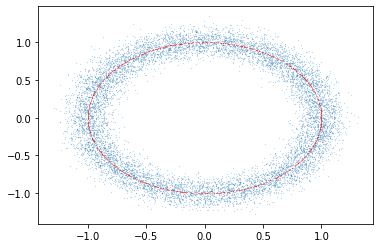

In [4]:
x, y = datapoints_in_a_circle(10000, 0.1)
y = to.from_numpy(y).float()
y=y.reshape((10000,1))
x = to.from_numpy(x).float()
x=x.reshape((10000,1))
data_ds = Dataset(x, y)

x_circ, y_circ= datapoints_in_a_circle(1000, 0)
plt.plot(x, y, '.', ms=0.2)
plt.plot(x_circ, y_circ, '.', color='r', ms=0.2)
plt.show()

In [57]:
epochs=10
bs=1000
n=y.shape[0]
m=x.shape[1]
nh=50
nz=10
dsteps=1
gsteps=3
m

1

In [58]:
def collate(b):
    xs,ys = zip(*b)
    return to.stack(xs),to.stack(ys)

data_dl = DataLoader(data_ds, bs, sampler=RandomSampler(data_ds), collate_fn=collate)

In [108]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, y, x):
        x = to.cat([y ,x], dim=1)
        for l in self.layers: x = l(x)
        return x

In [109]:
loss_func = nn.BCELoss()
def accuracy(out, yb): return (to.argmax(out, dim=1)==yb).float().mean()

In [110]:
lr=0.005
opt_g=optim.SGD(G.parameters(), lr=lr)
opt_d=optim.SGD(D.parameters(), lr=lr)

In [111]:

def circle_pen(data_gen):
    loss = to.abs(to.sqrt(data_gen[:,0]**2 + data_gen[:,1]**2)-1)
    return to.mean(loss)

def mean_pen(data, data_gen):
    loss = to.mean(to.abs((to.mean(data_gen, axis=0)-to.mean(data, axis=0))))
    return loss

def cov_pen(data, data_gen):
    n=len(data[:,0])
    cov_real=(1/n)*(data.T@data)
    cov_gen=(1/n)*(data_gen.T@data_gen)
    loss=to.mean(to.abs(cov_gen-cov_real))
    return loss   

In [112]:
Dlayers= [nn.Linear(m+1,nh), nn.ReLU(), nn.Linear(nh,nh), nn.ReLU(), nn.Linear(nh,1),nn.Sigmoid()]
Glayers= [nn.Linear(nz+m,nh), nn.ReLU(), nn.Linear(nh,nh),  nn.ReLU(), nn.Linear(nh, 1)]
D = Model(Dlayers)
G = Model(Glayers)



In [123]:
def fit(epochs, G, D, loss_func, opt_g, opt_d, data_dl, lambd):
    x_circ, y_circ= datapoints_in_a_circle(1000, 0)
    for epoch in range(epochs):
        for x, y in data_dl:
            for d in range(dsteps):
                D.train()
                G.eval()
                z=to.from_numpy(np.random.randn(bs, nz))
                z=z.float()
                
                d_real = D(y, x)
                y_gen= G(z, x)
                d_gen = D(y_gen, x) 
                
                Dloss_real = loss_func(d_real, to.ones((bs,1)))
                Dloss_gen = loss_func(d_gen, to.zeros((bs,1)))
                Dloss=.5*Dloss_real+.5*Dloss_gen
                Dloss.backward()
                opt_d.step()
                opt_d.zero_grad()
                opt_g.zero_grad()
            for g in range(gsteps):
                D.eval()
                G.train()
                z=to.from_numpy(np.random.randn(bs, nz))
                z=z.float()
               
                y_gen = G(z, y)
                d_gen = D(y , x)  
                
                Gloss = loss_func(d_gen, to.ones((bs,1)))
                Gloss.backward()
                opt_g.step()
                opt_g.zero_grad()
                opt_d.zero_grad()
                
            D.eval()
            G.eval()
        if (epoch+1) % 20 ==0:
            with to.no_grad():
                tot_loss_g,tot_loss_d = 0.,0.
                for data,yb in data_dl:
                    tot_loss_d += Dloss
                    tot_loss_g  += Gloss
                n = len(data_dl)
                print(epoch+1, tot_loss_g/n, tot_loss_d/n)
                
                x, y_gen=x.detach().numpy(), y_gen.detach().numpy()
                plt.plot(x, y_gen, '.', ms=0.4)
                plt.plot(x_circ, y_circ, '.', color='r', ms=0.4)
                plt.plot(x, y.detach().numpy(), '.', color='g', ms=0.4)
                plt.xlim((-1.4, 1.4))
                plt.ylim((-1.4, 1.4))
                plt.show()
    return G
#         print(model.training)


20 tensor(0.7819) tensor(0.6989)


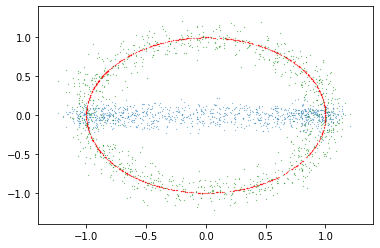

40 tensor(0.7809) tensor(0.6989)


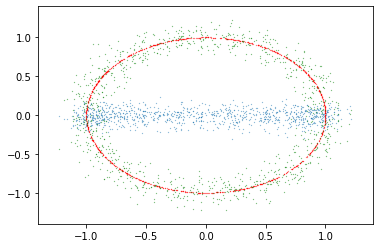

60 tensor(0.7817) tensor(0.6989)


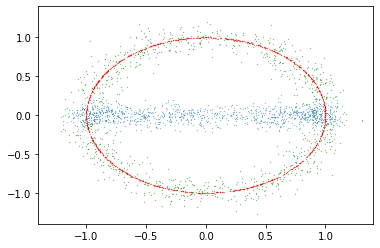

KeyboardInterrupt: 

In [124]:
G = fit(10000, G, D, loss_func, opt_g, opt_d, data_dl, lambd=[1,0, 1, 1])